<a href="https://colab.research.google.com/github/HQUT/Deep-Learning-in-Data-Science-/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install and Import**

In [ ]:
!pip install datasets
!pip install --upgrade datasets
!pip install torch
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
rm -rf ~/.cache/huggingface/datasets/code_search_net

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import json
from spellchecker import SpellChecker
from collections import Counter
import ast
from datasets import load_dataset
import io
import tokenize
from IPython.display import display
import pandas as pd
import seaborn as sns
import pandas as pd

# **Data Collection and Data Processing**

### ***Data Expolation***

In [ ]:
dataset = load_dataset("code_search_net", "python")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [ ]:
# Features of the datser
print(dataset['train'].features)
print(dataset['validation'].features)
print(dataset['test'].features)

# Understanding how the data look
for i in range(3):
    print(dataset['train'][i]['func_code_string'])
    print("=" * 60)

example = dataset['train'][0]
for k, v in example.items():
    print(f"{k}:\n{v}\n{'='*40}")

{'repository_name': Value(dtype='string', id=None), 'func_path_in_repository': Value(dtype='string', id=None), 'func_name': Value(dtype='string', id=None), 'whole_func_string': Value(dtype='string', id=None), 'language': Value(dtype='string', id=None), 'func_code_string': Value(dtype='string', id=None), 'func_code_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'func_documentation_string': Value(dtype='string', id=None), 'func_documentation_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'split_name': Value(dtype='string', id=None), 'func_code_url': Value(dtype='string', id=None)}
{'repository_name': Value(dtype='string', id=None), 'func_path_in_repository': Value(dtype='string', id=None), 'func_name': Value(dtype='string', id=None), 'whole_func_string': Value(dtype='string', id=None), 'language': Value(dtype='string', id=None), 'func_code_string': Value(dtype='string', id=None), 'func_code_tokens': Sequence(feature=Value(dt

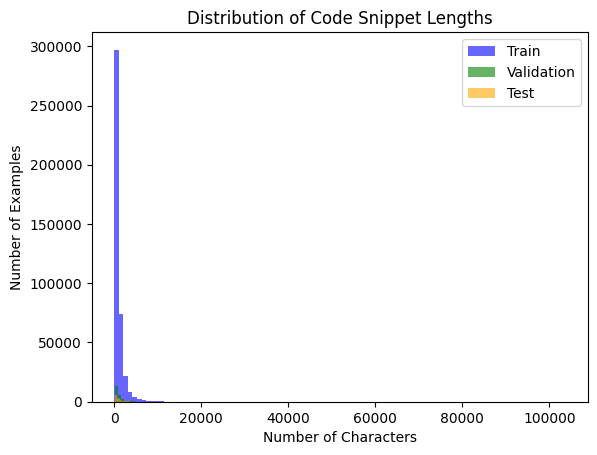

In [ ]:
# Length distribution of the code in the dataset
train_lengths = [len(ex['func_code_string']) for ex in dataset['train'] if ex['func_code_string']]
val_lengths = [len(ex['func_code_string']) for ex in dataset['validation'] if ex['func_code_string']]
test_lengths = [len(ex['func_code_string']) for ex in dataset['test'] if ex['func_code_string']]

plt.hist(train_lengths, bins=100, alpha=0.6, label='Train', color='blue')
plt.hist(val_lengths, bins=100, alpha=0.6, label='Validation', color='green')
plt.hist(test_lengths, bins=100, alpha=0.6, label='Test', color='orange')

plt.title("Distribution of Code Snippet Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Examples")
plt.legend()

plt.show()


In [ ]:
# Check if there is empty code
empty_codes = sum(1 for ex in dataset['train'] if not ex['func_code_string'].strip())
print(f"Empty code snippets in train: {empty_codes}")
empty_codes = sum(1 for ex in dataset['validation'] if not ex['func_code_string'].strip())
print(f"Empty code snippets in validation: {empty_codes}")
empty_codes = sum(1 for ex in dataset['test'] if not ex['func_code_string'].strip())
print(f"Empty code snippets intest: {empty_codes}")

Empty code snippets in train: 0
Empty code snippets in validation: 0
Empty code snippets intest: 0


### ***Data Processing***

In [ ]:
# Removing comments and docstring
def remove_comments_and_docstrings(source):
      try:
          io_obj = io.StringIO(source)
          out_tokens = []
          prev_toktype = tokenize.INDENT
          last_col = 0
          last_lineno = -1
          first_token = True
          for tok in tokenize.generate_tokens(io_obj.readline):
              token_type, token_string, start, end, line = tok
              if token_type == tokenize.COMMENT:
                  continue

              if token_type == tokenize.STRING:
                  if prev_toktype == tokenize.INDENT or first_token:
                      #out.append(token_string)
                      first_token = False
                      continue

              out_tokens.append((token_type, token_string))
              prev_toktype = token_type
              last_col = end[1]
              last_lineno = end[0]
              first_token = False
          return tokenize.untokenize(out_tokens)
      except Exception as e:
        print(f"Fel vid tokenisering: {e}")
        return ''
      cleaned_code = remove_comments_and_docstrings(raw_code)

      print("✔ Steg 2 – Rensad kod (utan kommentarer/docstrings):")
      print(cleaned_code)
      print("=" * 60)

      return cleaned_code

In [ ]:
def clean_code_split(split_data, max_len=5000):
      cleaned = []

      for i, ex in enumerate(split_data):
        code = ex.get('func_code_string', '')

        if not code or len(code) > max_len:
            continue

        cleaned_code = remove_comments_and_docstrings(code)

        if cleaned_code and len(cleaned_code.strip()) > 0:
            cleaned.append(cleaned_code)

        if i % 50000 == 0:
            print(f"✔ Function {i} Processed:\n{cleaned_code[:300]}\n{'='*60}")
      return cleaned

In [ ]:
train_clean = clean_code_split(dataset['train'])
val_clean = clean_code_split(dataset['validation'])
test_clean = clean_code_split(dataset['test'])

✔ Function 0 Processed:
def update (self ,field_dict ,where_clause =None ):

        query ='''
        UPDATE %s SET %s
        '''%(
        self ._name ,
        ','.join ('%s=:%s'%(k ,k )for k in field_dict )
        )
        if where_clause :
            query +=' WHERE %s'%(where_clause )
        self ._cursor .exec
Fel vid tokenisering: ('EOF in multi-line statement', (19, 0))
✔ Function 50000 Processed:
def _get_num_parallel_threads (max_threads ,num_cores ,mem_available_mb ):

    return min (max_threads ,num_cores ,max (int (mem_available_mb /1200 ),1 ))
✔ Function 100000 Processed:
def translate (source ,carrier ,reverse =False ,encoding =None ):

    if not isinstance (source ,unicode )and encoding :
        source =source .decode (encoding ,'replace')
    elif not isinstance (source ,unicode ):
        raise AttributeError (u"`source` must be decoded to `unicode` or set `enc
✔ Function 150000 Processed:
def html (self ):

        return self .render (self .data ,self .pro

In [ ]:
train_text = "\n".join(train_clean)
val_text = "\n".join(val_clean)
test_text = "\n".join(test_clean)

print("First 1000 characters of train_text:")
print(train_text[:1000])
print("=" * 60)

print("First 1000 characters of val_text:")
print(val_text[:1000])
print("=" * 60)

print("First 1000 characters of test_text:")
print(test_text[:1000])
print("=" * 60)

First 1000 characters of train_text:
def update (self ,field_dict ,where_clause =None ):

        query ='''
        UPDATE %s SET %s
        '''%(
        self ._name ,
        ','.join ('%s=:%s'%(k ,k )for k in field_dict )
        )
        if where_clause :
            query +=' WHERE %s'%(where_clause )
        self ._cursor .execute (query ,field_dict )
        self ._connection .commit ()
def insert (self ,fields ,values ):

        if fields :
            _fields =' (%s) '%','.join (fields )
        else :
            _fields =''
        _values =','.join ('?'*len (values ))
        query ='''
        INSERT INTO %s %s VALUES (%s)
        '''%(self ._name ,_fields ,_values )
        self ._cursor .execute (query ,tuple (values ))
        self ._connection .commit ()
        return self ._cursor .lastrowid 
def store (self ,report ,test_id ):

        report_d =report .to_dict ()
        content =self ._serialize_dict (report_d )
        report_id =self .insert (
        ['test_

In [ ]:
# Find the unique char and do the mapping
vocab = sorted(set(train_text))

print(f"Number of unique characters: {len(vocab)}")
print(f"Exempel: {vocab[:20]}")

char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = list(vocab)
torch.save(char2idx, "char2idx.pt")
torch.save(idx2char, "idx2char.pt")

Number of unique characters: 3033
Exempel: ['\x03', '\x04', '\t', '\n', '\r', '\x1b', '\x1f', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',']


In [ ]:
# convert
train_as_int = [char2idx[c] for c in train_text]
val_as_int = [char2idx[c] for c in val_text if c in char2idx]
test_as_int = [char2idx[c] for c in test_text if c in char2idx]
train_text_str = ''.join([idx2char[i] for i in train_as_int])
print(f"Length of train_as_int: {len(train_as_int)}")
print(f"First 20 index of train_as_int: {train_as_int[:20]}")

Length of train_as_int: 236354599
First 20 index of train_as_int: [75, 76, 77, 7, 92, 87, 75, 72, 91, 76, 7, 15, 90, 76, 83, 77, 7, 19, 77, 80]


In [ ]:
class EfficientCharDataset(Dataset):
    '''This class efficiently generates batches of sequential character data for training
    RNN models by reshaping the dataset into parallel streams.
    '''
    def __init__(self, data, seq_length, batch_size):
        self.seq_length = seq_length
        self.batch_size = batch_size
        total_len = (len(data) // (seq_length * batch_size)) * (seq_length * batch_size)
        self.data = torch.tensor(data[:total_len], dtype=torch.long)
        self.data = self.data.view(batch_size, -1)

    def __len__(self):
        return self.data.size(1) // self.seq_length

    def __getitem__(self, idx):
        x = self.data[:, idx * self.seq_length : (idx + 1) * self.seq_length]
        y = self.data[:, idx * self.seq_length + 1 : (idx + 1) * self.seq_length + 1]

        # Om y är för kort, trimma x
        if y.size(1) != self.seq_length:
          x = x[:, :y.size(1)]
        return x, y

# **Modell architecture**

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, model_type='LSTM', num_layers=1):
        super().__init__()
        self.model_type = model_type.upper()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if self.model_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        elif self.model_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


# **Train for Grid Search**

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device, epochs, log_every=1000):
    model.train()
    step_losses = []
    total_steps = len(dataloader) * epochs
    step = 0
    start_time = time.time()

    for epoch in range(epochs):
        print(f"\n Epoch {epoch+1}/{epochs}")
        for x, y in dataloader:
            x, y = x.squeeze(0).to(device), y.squeeze(0).to(device)

            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            step_losses.append((step, loss.item()))

            if step % log_every == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (step+1)) * (total_steps - step)
                print(f"Step {step}/{total_steps} | Loss: {loss.item():.4f} | ETA: {eta/60:.1f} min")

            step += 1

    return step_losses

In [ ]:
def run_rnn_grid_search(train_data, vocab_size, seq_length, embedding_dim, char2idx,
                        idx2char, device, model_class, model_name="model", model_type='LSTM',
                        num_layers=1, epochs=2, log_every=1000):
    hidden_sizes = [128, 256]
    batch_sizes = [32, 64]
    learning_rates = [1e-3, 5e-4]
    results = []
    best_model = None

    for hidden_size in hidden_sizes:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                print(f"\n Tränar: {model_name} | hidden={hidden_size}, batch={batch_size}, lr={lr}")
                dataset = EfficientCharDataset(train_data, seq_length, batch_size)
                dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

                # Skapa modell med alla flexibla parametrar
                model = model_class(
                    vocab_size,
                    embedding_dim,
                    hidden_size,
                    model_type=model_type,
                    num_layers=num_layers
                ).to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                criterion = nn.CrossEntropyLoss()

                step_losses = train_model(model, dataloader, optimizer, criterion, device, epochs, log_every)
                avg_loss = sum(l for _, l in step_losses) / len(step_losses)

                path = f"{model_name}_h{hidden_size}_b{batch_size}_lr{lr}.pt"
                torch.save(model.state_dict(), path)
                print(f"Sparade modell till {path}")

                results.append({
                    "model_type": model_type,
                    "num_layers": num_layers,
                    "hidden_size": hidden_size,
                    "batch_size": batch_size,
                    "learning_rate": lr,
                    "avg_loss": avg_loss,
                    "path": path
                })

                if best_model is None or avg_loss < best_model["avg_loss"]:
                    best_model = results[-1]

    print(f"\n Bästa modellen ({model_name}): {best_model}")
    return results, best_model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
subset_data = train_as_int[:5_000_000]

### *Grid Search loop*

In [ ]:
common_grid_params = {
    "train_data": subset_data,
    "vocab_size": vocab_size,
    "seq_length": 100,
    "embedding_dim": 256,
    "char2idx": char2idx,
    "idx2char": idx2char,
    "device": device,
    "epochs": 3
}

grid_configs = [
    {
        "model_class": CharRNN,
        "model_name": "RNN",
        "model_type": "RNN",
        "num_layers": 1
    },
    {
        "model_class": CharRNN,
        "model_name": "LSTM-1",
        "model_type": "LSTM",
        "num_layers": 1
    },
    {
        "model_class": CharRNN,
        "model_name": "LSTM-2",
        "model_type": "LSTM",
        "num_layers": 2
    }
]

results = {}
bests = {}

for config in grid_configs:
    results_key = config["model_name"]
    results[results_key], bests[results_key] = run_rnn_grid_search(
        model_class=config["model_class"],
        model_name=config["model_name"],
        model_type=config["model_type"],
        num_layers=config["num_layers"],
        **common_grid_params
    )



 Tränar: RNN | hidden=128, batch=32, lr=0.001

 Epoch 1/3
Step 0/4686 | Loss: 8.1568 | ETA: 60.3 min
Step 1000/4686 | Loss: 1.9093 | ETA: 0.2 min

 Epoch 2/3
Step 2000/4686 | Loss: 1.6197 | ETA: 0.2 min
Step 3000/4686 | Loss: 1.6305 | ETA: 0.1 min

 Epoch 3/3
Step 4000/4686 | Loss: 1.6639 | ETA: 0.0 min
Sparade modell till RNN_h128_b32_lr0.001.pt

 Tränar: RNN | hidden=128, batch=32, lr=0.0005

 Epoch 1/3
Step 0/4686 | Loss: 8.0827 | ETA: 0.3 min
Step 1000/4686 | Loss: 1.8992 | ETA: 0.2 min

 Epoch 2/3
Step 2000/4686 | Loss: 1.8290 | ETA: 0.1 min
Step 3000/4686 | Loss: 1.6802 | ETA: 0.1 min

 Epoch 3/3
Step 4000/4686 | Loss: 1.5864 | ETA: 0.0 min
Sparade modell till RNN_h128_b32_lr0.0005.pt

 Tränar: RNN | hidden=128, batch=64, lr=0.001

 Epoch 1/3
Step 0/2343 | Loss: 8.0783 | ETA: 0.3 min

 Epoch 2/3
Step 1000/2343 | Loss: 1.8290 | ETA: 0.1 min

 Epoch 3/3
Step 2000/2343 | Loss: 1.6530 | ETA: 0.0 min
Sparade modell till RNN_h128_b64_lr0.001.pt

 Tränar: RNN | hidden=128, batch=64, lr

# **Finetuning**

In [ ]:
def train_with_early_stopping(
    model, dataloader, optimizer, criterion, device,
    max_epochs=10, patience=2, log_every=10000,
    save_path="best_model.pt"
):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    all_losses = []
    best_state = None

    for epoch in range(max_epochs):
        print(f"\nFinetune Epoch {epoch+1}/{max_epochs}")
        epoch_loss = 0
        step = 0
        for x, y in dataloader:
            x, y = x.squeeze(0).to(device), y.squeeze(0).to(device)

            if 'batch_size' not in locals():
                batch_size = x.size(0)
                seq_length = x.size(1)

            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            all_losses.append((len(all_losses), loss.item()))

            if step % log_every == 0:
                print(f"Step {step} | Loss: {loss.item():.4f}")
            step += 1

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Genomsnittlig loss för epoch {epoch+1}: {avg_epoch_loss:.4f}")

        # Early stopping
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Tidigt stopp: ingen förbättring på", patience, "epoker.")
                break

    if best_state:
      torch.save(best_state, save_path)
      print(f"✅ Sparade bästa modellen till {save_path}")
    else:
      print("⚠️ Ingen förbättring under träningen – ingen modell sparad.")


    # Plotta
    #plot_loss(all_losses)
    plot_smoothed_loss(all_losses)

    return all_losses


In [ ]:
def finetune_model(model_path, model_name, vocab_size, embedding_dim, hidden_size,
                   seq_length, batch_size, device, model_type='LSTM', num_layers=1,
                   lr=1e-3, max_epochs=3, patience=2):

    print(f"\n🔧 Finetunar modell: {model_name}")
    dataset = EfficientCharDataset(train_as_int, seq_length, batch_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    model = CharRNN(
        vocab_size,
        embedding_dim,
        hidden_size,
        model_type=model_type,
        num_layers=num_layers
    ).to(device)

    model.load_state_dict(torch.load(model_path))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    save_path = f"finetuned_{model_name}.pt"
    losses = train_with_early_stopping(
        model, dataloader, optimizer, criterion, device,
        max_epochs=max_epochs, patience=patience,
        save_path=save_path
    )

    #return model, losses


In [ ]:
# Funktion för att plotta loss och smoothed loss
def plot_loss(losses):
    steps, values = zip(*losses)
    plt.plot(steps, values)
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

def plot_smoothed_loss(losses, smooth_window=100):
    import matplotlib.pyplot as plt
    steps, values = zip(*losses)
    smoothed = []
    for i in range(len(values)):
        start = max(0, i - smooth_window)
        avg = sum(values[start:i+1]) / (i - start + 1)
        smoothed.append(avg)

    plt.figure(figsize=(10, 4))
    plt.plot(steps, smoothed, linewidth=2)
    plt.xlabel("Training Step")
    plt.ylabel("Smoothed Loss")
    plt.title(f"Smoothed Training Loss (window={smooth_window})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### *Finetuning loop*


🔧 Finetunar modell: RNN

Finetune Epoch 1/3
Step 0 | Loss: 1.4453
Step 1000 | Loss: 1.3294
Step 2000 | Loss: 1.4199
Step 3000 | Loss: 1.3512
Step 4000 | Loss: 1.4561
Step 5000 | Loss: 1.3431
Step 6000 | Loss: 1.2575
Step 7000 | Loss: 1.3542
Step 8000 | Loss: 1.3451
Step 9000 | Loss: 1.4802
Step 10000 | Loss: 1.3642
Step 11000 | Loss: 1.3289
Step 12000 | Loss: 1.2077
Step 13000 | Loss: 1.4691
Step 14000 | Loss: 1.3405
Step 15000 | Loss: 1.3546
Step 16000 | Loss: 1.4129
Step 17000 | Loss: 1.3157
Step 18000 | Loss: 1.3497
Step 19000 | Loss: 1.2405
Step 20000 | Loss: 1.2616
Step 21000 | Loss: 1.3712
Step 22000 | Loss: 1.3060
Step 23000 | Loss: 1.2564
Step 24000 | Loss: 1.4009
Step 25000 | Loss: 1.3178
Step 26000 | Loss: 1.4912
Step 27000 | Loss: 1.3473
Step 28000 | Loss: 1.2619
Step 29000 | Loss: 1.2675
Step 30000 | Loss: 1.2696
Step 31000 | Loss: 1.2923
Step 32000 | Loss: 1.4390
Step 33000 | Loss: 1.3430
Step 34000 | Loss: 1.3359
Step 35000 | Loss: 1.3368
Step 36000 | Loss: 1.3880
Step 3

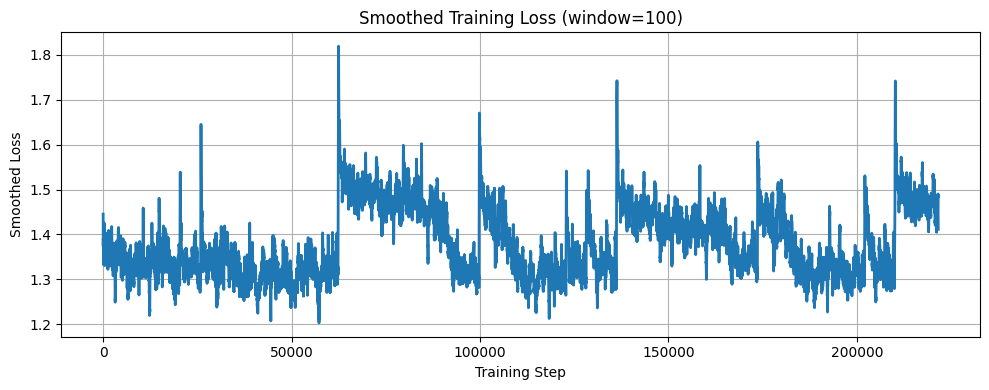


🔧 Finetunar modell: LSTM1

Finetune Epoch 1/3
Step 0 | Loss: 1.4121
Step 1000 | Loss: 1.2712
Step 2000 | Loss: 1.3452
Step 3000 | Loss: 1.2572
Step 4000 | Loss: 1.3729
Step 5000 | Loss: 1.2758
Step 6000 | Loss: 1.1960
Step 7000 | Loss: 1.2852
Step 8000 | Loss: 1.2491
Step 9000 | Loss: 1.3827
Step 10000 | Loss: 1.2607
Step 11000 | Loss: 1.2482
Step 12000 | Loss: 1.0987
Step 13000 | Loss: 1.3458
Step 14000 | Loss: 1.2195
Step 15000 | Loss: 1.2155
Step 16000 | Loss: 1.2660
Step 17000 | Loss: 1.1998
Step 18000 | Loss: 1.2078
Step 19000 | Loss: 1.1285
Step 20000 | Loss: 1.1672
Step 21000 | Loss: 1.1674
Step 22000 | Loss: 1.1570
Step 23000 | Loss: 1.1139
Step 24000 | Loss: 1.2539
Step 25000 | Loss: 1.1891
Step 26000 | Loss: 1.1682
Step 27000 | Loss: 1.1504
Step 28000 | Loss: 1.0936
Step 29000 | Loss: 1.1399
Step 30000 | Loss: 1.1384
Step 31000 | Loss: 1.1564
Step 32000 | Loss: 1.2738
Step 33000 | Loss: 1.1784
Step 34000 | Loss: 1.1452
Step 35000 | Loss: 1.1871
Step 36000 | Loss: 1.1797
Step

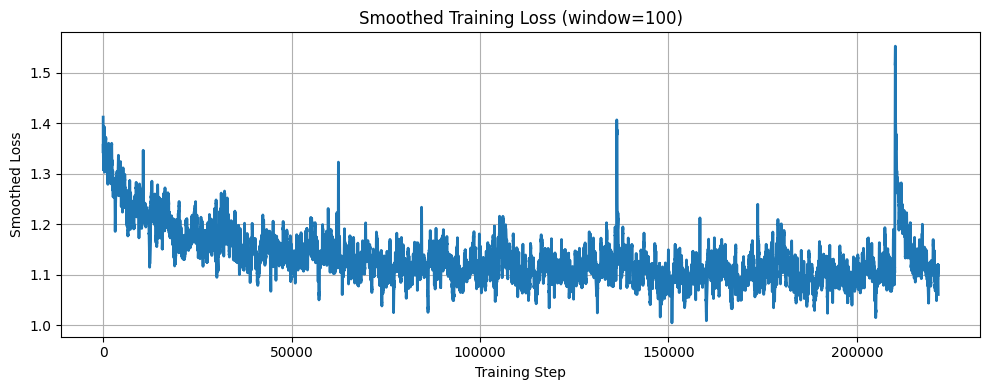


🔧 Finetunar modell: LSTM2

Finetune Epoch 1/3
Step 0 | Loss: 1.3583
Step 1000 | Loss: 1.2071
Step 2000 | Loss: 1.2780
Step 3000 | Loss: 1.1928
Step 4000 | Loss: 1.3234
Step 5000 | Loss: 1.2030
Step 6000 | Loss: 1.1232
Step 7000 | Loss: 1.1952
Step 8000 | Loss: 1.1446
Step 9000 | Loss: 1.2929
Step 10000 | Loss: 1.1779
Step 11000 | Loss: 1.1327
Step 12000 | Loss: 1.0329
Step 13000 | Loss: 1.2590
Step 14000 | Loss: 1.1233
Step 15000 | Loss: 1.1284
Step 16000 | Loss: 1.1752
Step 17000 | Loss: 1.1053
Step 18000 | Loss: 1.1242
Step 19000 | Loss: 1.0425
Step 20000 | Loss: 1.0729
Step 21000 | Loss: 1.0618
Step 22000 | Loss: 1.0614
Step 23000 | Loss: 1.0315
Step 24000 | Loss: 1.1589
Step 25000 | Loss: 1.0929
Step 26000 | Loss: 1.0938
Step 27000 | Loss: 1.0568
Step 28000 | Loss: 1.0396
Step 29000 | Loss: 1.0666
Step 30000 | Loss: 1.0421
Step 31000 | Loss: 1.0867
Step 32000 | Loss: 1.1903
Step 33000 | Loss: 1.0720
Step 34000 | Loss: 1.0713
Step 35000 | Loss: 1.0911
Step 36000 | Loss: 1.0706
Step

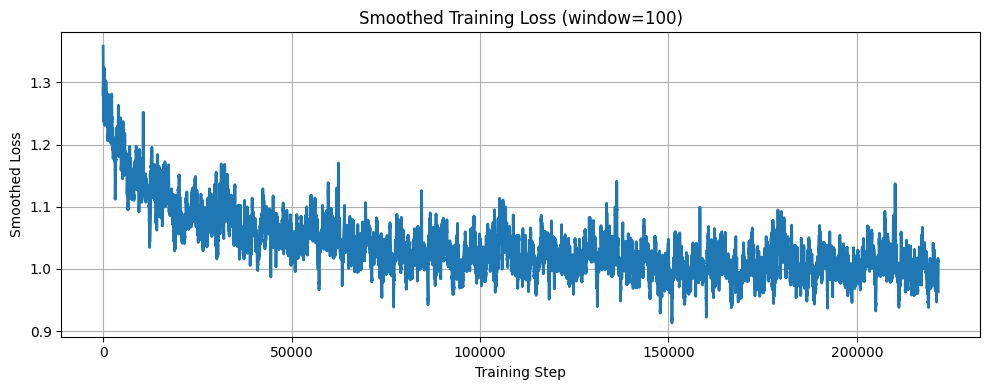

In [ ]:
model_configs = [
    {
        "model_path": "RNN_h256_b32_lr0.001.pt",
        "model_name": "RNN",
        "model_type": "RNN",
        "num_layers": 1
    },
    {
        "model_path": "LSTM-1_h256_b32_lr0.001.pt",
        "model_name": "LSTM1",
        "model_type": "LSTM",
        "num_layers": 1
    },
    {
        "model_path": "LSTM-2_h256_b32_lr0.001.pt",
        "model_name": "LSTM2",
        "model_type": "LSTM",
        "num_layers": 2
    }
]

# Gemensamma parametrar
common_params = {
    "vocab_size": vocab_size,
    "embedding_dim": 256,
    "hidden_size": 256,
    "seq_length": 100,
    "batch_size": 32,
    "device": device,
}

# Loopa igenom konfigurationerna
for config in model_configs:
    finetune_model(
        model_path=config["model_path"],
        model_name=config["model_name"],
        model_type=config["model_type"],
        num_layers=config["num_layers"],
        **common_params
    )


# **Text Generation & Evaluation**

In [ ]:
def nucleus_sample(probs, p=0.9):
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    cutoff = cumulative_probs > p
    cutoff_idx = (cumulative_probs > p).float().argmax().item() + 1
    filtered_probs = sorted_probs[:cutoff_idx]
    filtered_indices = sorted_indices[:cutoff_idx]
    filtered_probs /= filtered_probs.sum()
    return filtered_indices[torch.multinomial(filtered_probs, 1)]
def generate_text(model, start_text, char2idx, idx2char, temperature, p, length, device):
    model.eval()
    input_chars = start_text
    input_indices = [char2idx[c] for c in input_chars]
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    generated_text = input_chars

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_tensor, hidden)
            output = output[:, -1, :] / temperature
            probs = torch.softmax(output, dim=-1)
            next_index = nucleus_sample(probs[0], p=p).item()

            generated_text += idx2char[next_index]
            input_tensor = torch.tensor([[next_index]], dtype=torch.long).to(device)

    return generated_text


In [ ]:
def show_generation_before_after(
    model_path_before,
    model_path_after,
    vocab_size,
    hidden_size,
    char2idx,
    idx2char,
    device,
    model_type="LSTM",
    num_layers=1,
    temperatures=[1.0],
    p_values=[0.9]
):
    texts = {}

    def load_and_generate(label, path):
        model = CharRNN(
            vocab_size, 256, hidden_size,
            model_type=model_type,
            num_layers=num_layers
        ).to(device)

        model.load_state_dict(torch.load(path))
        model.eval()

        for temp in temperatures:
          for p in p_values:
            key = f"{label}_temp{temp}_p{p}"
            text = generate_text(
                model, "def ", char2idx, idx2char,
                temperature=temp, p=p, length=600, device=device
            )
            texts[key] = text
            print(f"\n📌 {key}")
            print(text)

    load_and_generate("before", model_path_before)
    load_and_generate("after", model_path_after)
    return texts


In [ ]:
common_gen_params = {
    "vocab_size": len(vocab),
    "hidden_size": 256,
    "char2idx": char2idx,
    "idx2char": idx2char,
    "device": device,
    "temperatures": [1.0],
    "p_values": [0.9]
}
gen_configs = [
    {
        "model_path_before": "RNN_h256_b32_lr0.001.pt",
        "model_path_after": "finetuned_RNN.pt",
        "model_type": "RNN",
        "num_layers": 1,
        "model_name": "RNN"
    },
    {
        "model_path_before": "LSTM-1_h256_b32_lr0.001.pt",
        "model_path_after": "finetuned_LSTM1.pt",
        "model_type": "LSTM",
        "num_layers": 1,
        "model_name": "LSTM1"
    },
    {
        "model_path_before": "LSTM-2_h256_b32_lr0.001.pt",
        "model_path_after": "finetuned_LSTM2.pt",
        "model_type": "LSTM",
        "num_layers": 2,
        "model_name": "LSTM2"
    }
]
all_texts = {}

for config in gen_configs:
    all_texts[config["model_name"]] = show_generation_before_after(
        model_path_before=config["model_path_before"],
        model_path_after=config["model_path_after"],
        model_type=config["model_type"],
        num_layers=config["num_layers"],
        **common_gen_params
    )



📌 before_temp1.0_p0.9
def source =True ):

    p =Options ,"w")

                await model ,response :
                if next =self ._transcriptim :
                    return self ._emoging (self ):

                return unique =func 
                if self .channel [np .arg ()
        raise TypeError ("."))
    class .append (self ))

    accuracy (self .exit ("accounts ,output =False ,max (x ):


        if b )is not client ,metalit_dict =pos .getLineBasts",1 )

        if protory =opts .pointer 
def default_file =None ):




        if isinstance (args ):

    p =OptionParser =timeout is not None and not isin

📌 after_temp1.0_p0.9
def and (self ,
      return None ,
                response :
           reader_non ="req %s"%chil =installabections ['messuperams refull-configure'):

                         raise else )
          response 
                if specifient =type :
           if python_id ]=streams ['segment founding not back'].info (dict )

      args =g )
       

### *n-gram*

In [ ]:

def get_test_text(dataset, max_chars=600):
    test_code = ""
    for ex in dataset["test"]:
        snippet = ex.get("func_code_string", "").strip()
        if snippet:
            test_code += snippet + "\n"
        if len(test_code) >= max_chars:
            break
    return test_code[:max_chars]

def ngram_overlap(text1, text2, n):
    def get_ngrams(text, n):
        return list(zip(*[text[i:] for i in range(n)]))
    ngrams1 = Counter(get_ngrams(text1, n))
    ngrams2 = Counter(get_ngrams(text2, n))
    common = sum((ngrams1 & ngrams2).values())
    total = sum(ngrams1.values()) or 1
    return 100 * common / total

def compare_generated_vs_test_ngram(
    model_configs,
    dataset,
    char2idx,
    idx2char,
    vocab_size,
    hidden_size,
    device,
    temperatures=[1.0],
    p_values=[0.9],
    length=600
):
    test_ref = get_test_text(dataset, max_chars=length)
    results = []

    for config in model_configs:
        name = config["name"]
        model_type = config.get("model_type", "LSTM")
        num_layers = config.get("num_layers", 1)
        path = config["path_after"]

        print(f"\n🔍 Genererar text från: {name}")


        model = CharRNN(
            vocab_size, 256, hidden_size,
            model_type=model_type,
            num_layers=num_layers
        ).to(device)
        model.load_state_dict(torch.load(path))
        model.eval()

        for temp in temperatures:
            for p in p_values:
                text = generate_text(
                    model, "def ", char2idx, idx2char,
                    temperature=temp, p=p, length=length, device=device
                )
                bigram = ngram_overlap(text, test_ref, 2)
                trigram = ngram_overlap(text, test_ref, 3)

                results.append({
                    "Model": name,
                    "Temperature": temp,
                    "p-value": p,
                    "Bigram vs Test (%)": round(bigram, 2),
                    "Trigram vs Test (%)": round(trigram, 2)
                })

    return pd.DataFrame(results)



In [ ]:
model_configs = [
    {
        "name": "RNN",
        "path_after": "finetuned_RNN.pt",
        "model_type": "RNN",
        "num_layers": 1
    },
    {
        "name": "LSTM1",
        "path_after": "finetuned_LSTM1.pt",
        "model_type": "LSTM",
        "num_layers": 1
    },
    {
        "name": "LSTM2",
        "path_after": "finetuned_LSTM2.pt",
        "model_type": "LSTM",
        "num_layers": 2
    }
]

df_ngram_test = compare_generated_vs_test_ngram(
    model_configs=model_configs,
    dataset=dataset,
    char2idx=char2idx,
    idx2char=idx2char,
    vocab_size=len(vocab),
    hidden_size=256,
    device=device,
    temperatures=[0.7, 1.0],
    p_values=[0.8, 0.9],
    length=600
)

display(df_ngram_test)



🔍 Genererar text från: RNN

🔍 Genererar text från: LSTM1

🔍 Genererar text från: LSTM2


,Model,Temperature,p-value,Bigram vs Test (%),Trigram vs Test (%)
0,RNN,0.7,0.8,15.26,12.46
1,RNN,0.7,0.9,15.75,12.79
2,RNN,1.0,0.8,17.74,13.29
3,RNN,1.0,0.9,38.14,20.60
4,LSTM1,0.7,0.8,37.48,21.10
5,LSTM1,0.7,0.9,27.36,19.10
6,LSTM1,1.0,0.8,39.14,22.92
7,LSTM1,1.0,0.9,34.66,18.60
8,LSTM2,0.7,0.8,35.99,22.26
9,LSTM2,0.7,0.9,38.31,24.25


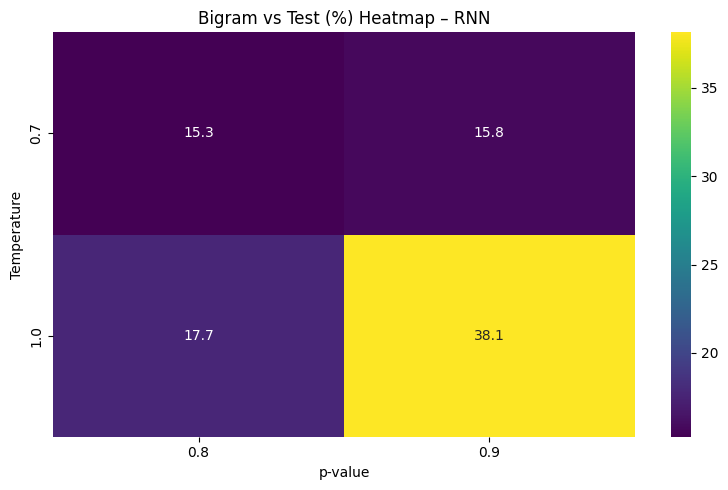

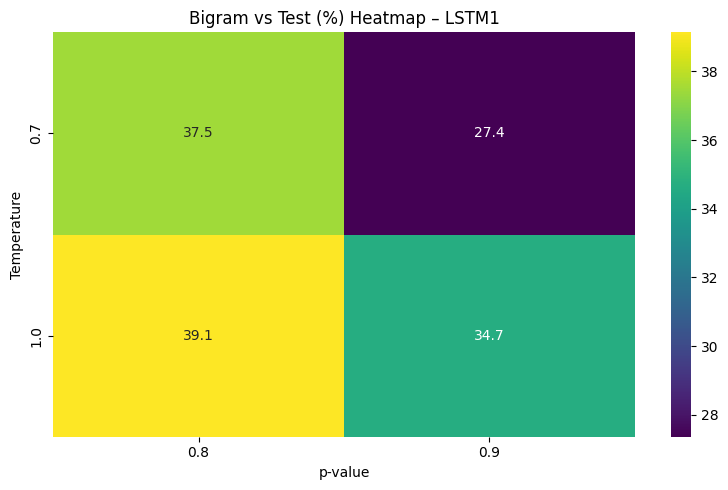

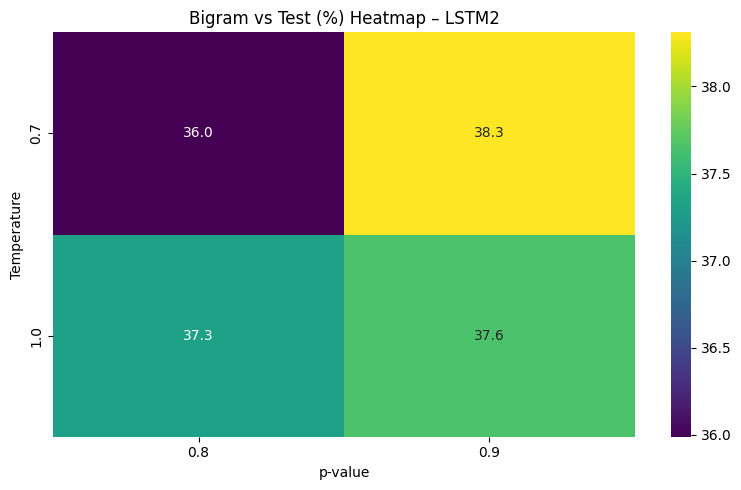

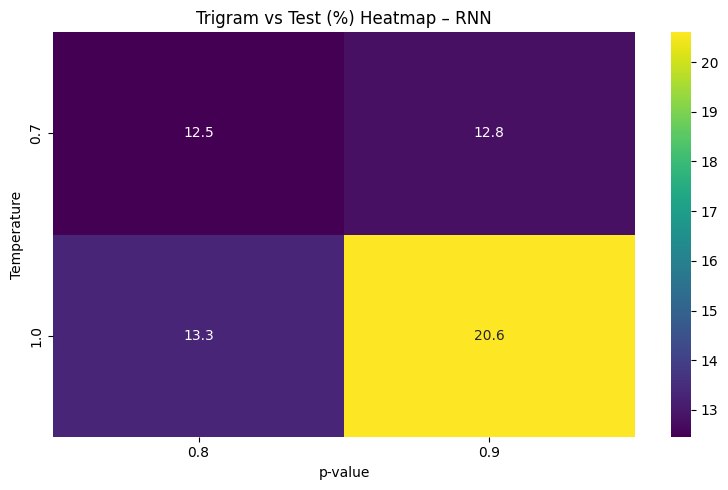

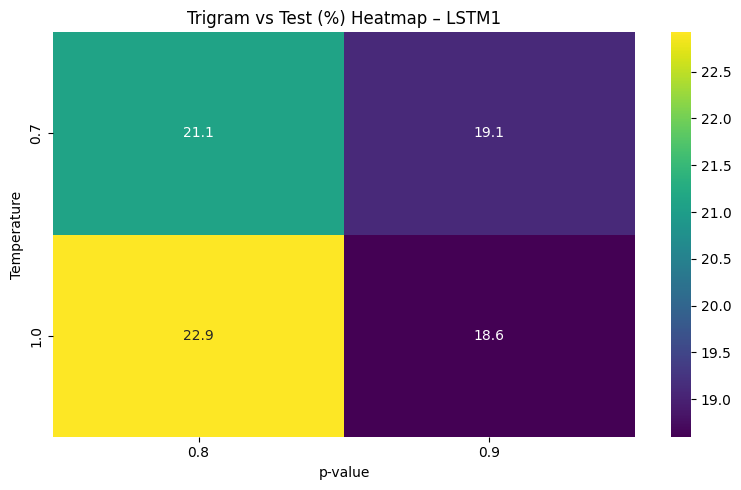

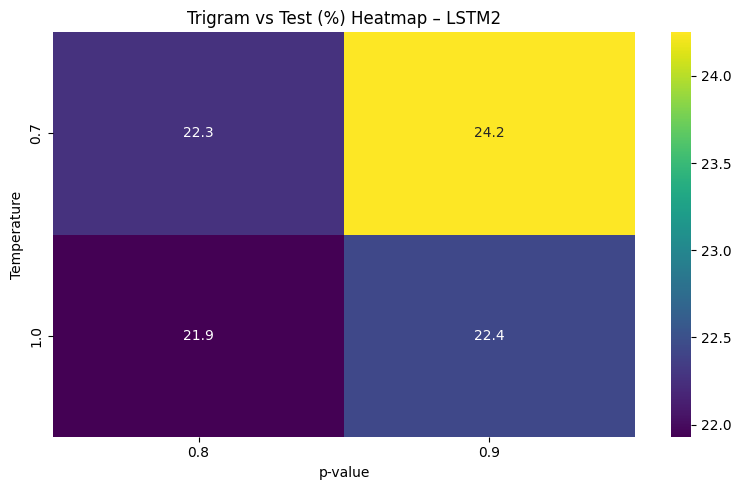

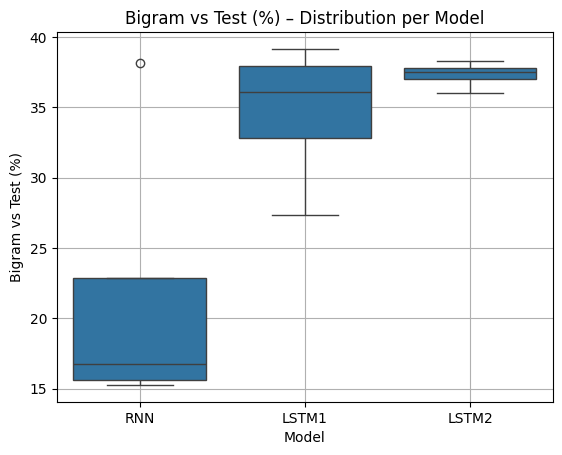

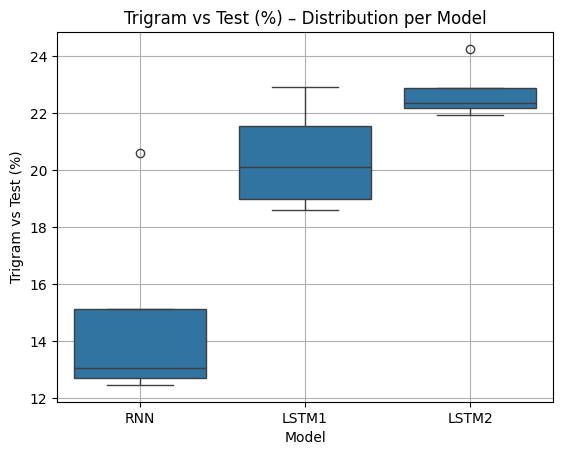

In [ ]:
def plot_ngram_heatmaps(df, ngram_type="Bigram Overlap (%)"):
    models = df["Model"].unique()
    for model in models:
        sub = df[df["Model"] == model]
        pivot = sub.pivot(index="Temperature", columns="p-value", values=ngram_type)

        plt.figure(figsize=(8, 5))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
        plt.title(f"{ngram_type} Heatmap – {model}")
        plt.xlabel("p-value")
        plt.ylabel("Temperature")
        plt.tight_layout()
        plt.show()

def boxplot_ngram(df, ngram_type="Bigram Overlap (%)"):
    sns.boxplot(data=df, x="Model", y=ngram_type)
    plt.title(f"{ngram_type} – Distribution per Model")
    plt.ylabel(ngram_type)
    plt.grid(True)
    plt.show()


plot_ngram_heatmaps(df_ngram_test, "Bigram vs Test (%)")
plot_ngram_heatmaps(df_ngram_test, "Trigram vs Test (%)")

boxplot_ngram(df_ngram_test, "Bigram vs Test (%)")
boxplot_ngram(df_ngram_test, "Trigram vs Test (%)")

In [ ]:
import re
def clean_words(text):
    return [word for word in re.findall(r'\b[a-zA-Z]+\b', text)]

def spelling_accuracy(text):
    spell = SpellChecker(language='en')
    words = clean_words(text)
    total = len(words)
    if total == 0:
        return 0.0
    misspelled = spell.unknown(words)
    correct = total - len(misspelled)
    return 100 * correct / total

def compare_spelling_accuracy_across_models(
    model_configs,
    char2idx,
    idx2char,
    vocab_size,
    hidden_size,
    device,
    temperatures=[1.0],
    p_values=[0.9],
    length=600
):
    results = []

    for config in model_configs:
        name = config["name"]
        path_before = config["path_before"]
        path_after = config["path_after"]
        model_type = config.get("model_type", "LSTM")
        num_layers = config.get("num_layers", 1)

        print(f"\n🔍 Modell: {name}")

        def load_model(path):
            model = CharRNN(
                vocab_size, 256, hidden_size,
                model_type=model_type,
                num_layers=num_layers
            ).to(device)
            model.load_state_dict(torch.load(path))
            model.eval()
            return model

        model_before = load_model(path_before)
        model_after = load_model(path_after)

        for label, model in [("Before", model_before), ("After", model_after)]:
            for temp in temperatures:
                for p in p_values:
                    text = generate_text(
                        model, "def ", char2idx, idx2char,
                        temperature=temp, p=p, length=length, device=device
                    )
                    acc = spelling_accuracy(text)
                    results.append({
                        "Model": name,
                        "Stage": label,
                        "Temperature": temp,
                        "p-value": p,
                        "Spelling Accuracy (%)": round(acc, 2)
                    })

    df = pd.DataFrame(results)
    return df


In [ ]:
model_configs = [
    {
        "name": "RNN",
        "path_before": "RNN_h256_b32_lr0.001.pt",
        "path_after": "finetuned_RNN.pt",
        "model_type": "RNN",
        "num_layers": 1
    },
    {
        "name": "LSTM1",
        "path_before": "LSTM-1_h256_b32_lr0.001.pt",
        "path_after": "finetuned_LSTM1.pt",
        "model_type": "LSTM",
        "num_layers": 1
    },
    {
        "name": "LSTM2",
        "path_before": "LSTM-2_h256_b32_lr0.001.pt",
        "path_after": "finetuned_LSTM2.pt",
        "model_type": "LSTM",
        "num_layers": 2
    }
]

df_spell = compare_spelling_accuracy_across_models(
    model_configs,
    char2idx=char2idx,
    idx2char=idx2char,
    vocab_size=len(vocab),
    hidden_size=256,
    device=device,
    temperatures=[0.7, 1.0],
    p_values=[0.8, 0.9],
    length=600
)
display(df_spell)


🔍 Modell: RNN

🔍 Modell: LSTM1

🔍 Modell: LSTM2


,Model,Stage,Temperature,p-value,Spelling Accuracy (%)
0,RNN,Before,0.7,0.8,84.62
1,RNN,Before,0.7,0.9,83.78
2,RNN,Before,1.0,0.8,85.00
3,RNN,Before,1.0,0.9,79.25
4,RNN,After,0.7,0.8,66.67
5,RNN,After,0.7,0.9,50.00
6,RNN,After,1.0,0.8,33.33
7,RNN,After,1.0,0.9,76.67
8,LSTM1,Before,0.7,0.8,85.37
9,LSTM1,Before,0.7,0.9,78.18
